# Problem set #2
## By Cooper Nederhood

### Problem #1:

In [166]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy as sci


root = "C:/Users/Cooper/Documents/Winter 2018/Perspectives II/persp-model_W18/ProblemSets/PS2"
income_file = "incomes.txt"

income_data = np.loadtxt(root+"/"+income_file)


## 1a: Plot the histogram

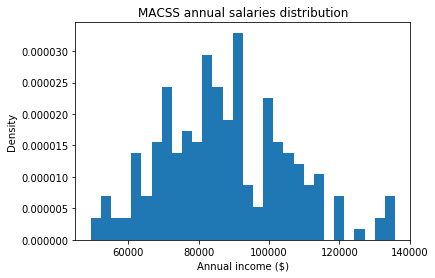

In [167]:
# Plot the histogram and a lognormal pdf with mu=11.0 and sigma=0.5 

mu = 11
sigma = .5
ln_dist = sts.lognorm(sigma, loc=mu)
    
n, bins, patches = plt.hist(income_data, bins=30, density=True)
plt.title("MACSS annual salaries distribution")
plt.xlabel("Annual income ($)")
plt.ylabel("Density")
plt.show()

In [168]:
def gen_ln_pdf(mu, sigma):
    '''
    Given mu and sigma, returns a ln pdf function
    which will calculate the pdf value according to mu and sigma
    
    Returns: pdf function
    '''
    
    def fn(x):
        exponent = ( (np.log(x) - mu)**2 ) /  (-2*(sigma**2)) 
        den = x * sigma * np.sqrt(2*np.pi)
        pdf = np.exp(exponent) / den
        
        return pdf
    
    return fn
        
    

## 1b: plot lognormal pdf and calculate log likelihood

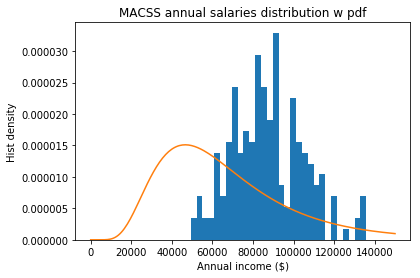

In [170]:
def loglik_lognormal(mu, sigma, data):
    '''
    Given mu and sigma and data
    
    Inputs:
        mu: lognormal assumption
        sigma: lognormal assumtpion
        data: empirical data
    
    Returns: loglikelihood given a lognormal distribution
    '''
      
    pdf_ln = gen_ln_pdf(mu, sigma)
    pdf_vals = pdf_ln(data)
    log_lik = sum(np.log(pdf_vals))
    
    return log_lik

# Plot
mu_orig = 11
sigma_orig = .5
pdf_ln_orig = gen_ln_pdf(mu_orig, sigma_orig)

n, bins, patches = plt.hist(income_data, bins=30, density=True)
plt.title("MACSS annual salaries distribution w pdf")
plt.xlabel("Annual income ($)")
plt.ylabel("Hist density")
plt.plot(np.linspace(0, 150000, 200), ln_orig(np.linspace(0.1, 150000, 200)))
plt.show()

In [171]:
ll_orig = loglik_lognormal(mu_orig, sigma_orig, income_data)
print("The loglikelihood given mu={} and sigma={} is: {}".format(mu_orig, sigma_orig, ll_orig))

The loglikelihood given mu=11 and sigma=0.5 is: -2385.856997808559


## 1c: Estimate parameters by MLE


In [172]:
def criterion_fn(params, data):
    '''
    Given a set of data and params (mu and sigma), returns the negative of the
    log likelihood function, assuming a lognormal distribution
    
    Inputs:
        params: (tuple) of length two, containing mu and sigma
        data: (numpy array) containing observed data
    Returns:
        ll: (scalar) of the negative of the loglikelihood given the data and params
    '''
    
    mu, sigma = params
    log_likelihood = loglik_lognormal(mu, sigma, data)
        
    return -log_likelihood


In [173]:
# Check our criterion function works (ie consistent with past calculation)
criterion_fn([mu_orig, sigma_orig], income_data)

2385.8569978085588

In [174]:
# Estimate MLE
params_init = np.array([mu_orig, sigma_orig])
mle_results = opt.minimize(criterion_fn, params_init, args=income_data, method='L-BFGS-B', bounds = ((None, None), (0.0001, None)) )


C:\Users\Cooper\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Cooper\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


In [175]:
# Print MLE results
mu_mle, sigma_mle = mle_results.x
ll_mle = loglik_lognormal(mu_mle, sigma_mle, income_data)
print("MLE finds mu={} and sigma={} with loglikelihood: {}".format(mu_mle, sigma_mle, ll_mle))

MLE finds mu=11.495016078797834 and sigma=0.31087915217170237 with loglikelihood: -2285.8999332824883


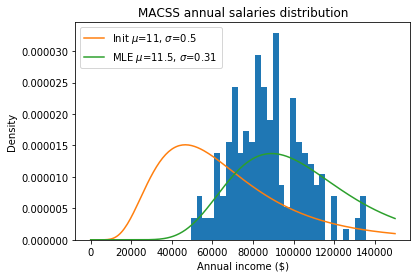

In [176]:
# Plot all results
# Plot
mu_orig = 11
sigma_orig = .5
pdf_ln_orig = gen_ln_pdf(mu_orig, sigma_orig)

pdf_ln_mle = gen_ln_pdf(mu_mle, sigma_mle)

n, bins, patches = plt.hist(income_data, bins=30, density=True)
plt.title("MACSS annual salaries distribution")
plt.xlabel("Annual income ($)")
plt.ylabel("Density")
plt.plot(np.linspace(0, 150000, 200), pdf_ln_orig(np.linspace(0.1, 150000, 200)), label="Init $\mu$={}, $\sigma$={}".format(mu_orig, sigma_orig))
plt.plot(np.linspace(0, 150000, 200), pdf_ln_mle(np.linspace(0.1, 150000, 200)) , label="MLE $\mu$={}, $\sigma$={}".format(round(mu_mle,2), round(sigma_mle,2)))
plt.legend()
plt.show()

In [177]:
# var/covar matrix (NOTE: bc we have taken the neg of the liklihood function we 'reverse' this by taking -1 of off-diagonals)
mat_neg_off_diag = np.array([ [1, -1] , [-1, 1] ])
vcv_mle = mle_results.hess_inv.todense() * mat_neg_off_diag
print("var/covar matrix for MLE estimates:")
print(vcv_mle)

var/covar matrix for MLE estimates:
[[  4.59466473e-04   6.65456823e-05]
 [  6.65456823e-05   1.71220931e-03]]


## 1d: Likelihood ratio test

In [178]:
test_stat_lr = 2 * (ll_mle - ll_orig)
pval_h0 = 1.0 - sts.chi2.cdf(test_stat_lr, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

chi squared of H0 with 2 degrees of freedom p-value =  0.0


The low p-value suggests that (assuming a lognormal distribution), we can reject mu=11 and sigma=0.5

## 1e: Estimate prob of certain incomes

In [179]:
def cdf_ln(x, mu, sigma):
    '''
    Given parameter assumptions, returns the CDF of the given x-value
    Inputs:
        mu: param for lognormal dist
        sigma: other param for lognormal dist
        x: target value
    Returns: CDF from lower bound to x
    '''
    ln_pdf = gen_ln_pdf(mu, sigma)
    
    prob = sci.integrate.quad(lambda y: ln_pdf(y), 0, x)
    return prob


In [180]:
prob_gt = 1 - cdf_ln(100000, mu_mle, sigma_mle)[0]
prob_lt = cdf_ln(75000, mu_mle, sigma_mle)[0]
print("Prob of earning GT $100,000: {}".format(prob_gt))
print("Prob of earning LT $75,000: {}".format(prob_lt))

Prob of earning GT $100,000: 0.47703010552564906
Prob of earning LT $75,000: 0.1927591731765454


# Problem 2:

## 2a: Estimate regression with MLE

In [181]:
# Load data
root = "C:/Users/Cooper/Documents/Winter 2018/Perspectives II/persp-model_W18/ProblemSets/PS2"
df = pd.read_csv(root+"/sick.txt")
df.head()


,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [182]:
# Define functions used to define optimize function
def calc_epsilon_hat(b_0, b_1, b_2, b_3, X_matrix):
    '''
    Given beta assumptions b0-b3, calculates empirical errors
    in the sick.txt dataset, which is denoted by X_matrix
    
    Inputs:
        b0-b3: coefficient estimates in linear regression
        X_matrix: Pandas DF containing the sick.txt data
    Returns: series of calculated errors (epsilons)
    '''
    
    ones = pd.Series(  np.ones(X_matrix.shape[0])   )  
    
    eps_hat = X_matrix['sick'] - b_0*ones - b_1*X_matrix['age'] - b_2*X_matrix['children'] - b_3*X_matrix['avgtemp_winter']
    
    return eps_hat

def gen_normal_pdf(mu, sigma):
    '''
    Given mu and sigma, returns a pdf function
    which will calculate the normal pdf value according to mu and sigma
    
    Returns: normal pdf function
    '''
    
    def fn(x):
        exponent = ( (x - mu)**2 ) /  (-2*(sigma**2)) 
        den = sigma * np.sqrt(2*np.pi)
        pdf = np.exp(exponent) / den
        
        return pdf
    
    return fn
        
    
def log_likelihood_reg(b_0, b_1, b_2, b_3, sigma, data ):
    '''
    Assuming errors are N(0, sigma**2) returns the loglikelihood corresponding
    to the beta[0-3] assumptions and the sigma assumption. "sick.txt" reflected in data
    
    Inputs:
        b0-b3: coefficient estimates in linear regression
        data: Pandas DF containing the sick.txt data
        sigma: sigma parameter in normal distribution
    
    Returns: loglikelihood
    '''
    
    normal_pdf = gen_normal_pdf(0, sigma)
    eps_hat = calc_epsilon_hat(b_0, b_1, b_2, b_3, data)
    
    pdf_vals = normal_pdf(eps_hat)
    log_likelihood = sum(np.log(pdf_vals))
    
    return log_likelihood

def criterion_fn_normal(params, data):
    '''
    Given a set of data and params (b0-b3, sigma), returns the negative of the
    log likelihood function, assuming a normal distribution
    
    
    Inputs:
        params: (tuple) of length 5, containing b0-b3 and sigma
        data: (dataframe) containing sick.txt data
    Returns:
        ll: (scalar) of the negative of the loglikelihood given the data and params
    '''
    
    
    b_0, b_1, b_2, b_3, sigma = params
    log_likelihood = log_likelihood_reg(b_0, b_1, b_2, b_3, sigma, data )
    print(params, -log_likelihood)
    
    return -log_likelihood    


In [183]:
# Check criterion fn is consistent with likelihood function
#b0, b1, b2, b3, sigma = [0.2516445 ,  0.01293344,  0.40050132, -0.00999168,  0.0030177]
b0, b1, b2, b3, sigma = [0 ,  0,  0, 0,  1]

print(log_likelihood_reg(b0, b1, b2, b3, sigma, df))

-310.812006641


In [184]:
init_params = np.array([0 ,  0,  0, 0,  1])
print(criterion_fn_normal(init_params, df))

[0 0 0 0 1] 310.812006641
310.812006641


In [185]:
# Do MLE estimation
mle_reg = opt.minimize(criterion_fn_normal, init_params, args=df )


[ 0.  0.  0.  0.  1.] 310.812006641
[  1.49011612e-08   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00] 310.812003635
[  0.00000000e+00   1.49011612e-08   0.00000000e+00   0.00000000e+00
   1.00000000e+00] 310.811872114
[  0.00000000e+00   0.00000000e+00   1.49011612e-08   0.00000000e+00
   1.00000000e+00] 310.812000163
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.49011612e-08
   1.00000000e+00] 310.811876013
[ 0.          0.          0.          0.          1.00000001] 310.812005836
[ 0.  0.  0.  0.  1.] 310.812006641
[ 0.01617855  0.72407008  0.03486715  0.7030834   1.00433486] inf
[ 0.01617855  0.72407008  0.03486715  0.7030834   1.00433486] inf
[ 0.01617856  0.72407008  0.03486715  0.7030834   1.00433486] inf
[ 0.01617855  0.72407009  0.03486715  0.7030834   1.00433486] inf
[ 0.01617855  0.72407008  0.03486717  0.7030834   1.00433486] inf
[ 0.01617855  0.72407008  0.03486715  0.70308341  1.00433486] inf
[ 0.01617855  0.72407008  0.03486715  0.7030834 

C:\Users\Cooper\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log
C:\Users\Cooper\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


[  2.01719990e-98   9.02796783e-97   4.34736301e-98   8.76629833e-97
   1.00000000e+00] 310.812006641
[  2.01719990e-98   9.02796783e-97   4.34736301e-98   8.76629833e-97
   1.00000000e+00] 310.812006641
[  1.49011612e-08   9.02796783e-97   4.34736301e-98   8.76629833e-97
   1.00000000e+00] 310.812003635
[  2.01719990e-98   1.49011612e-08   4.34736301e-98   8.76629833e-97
   1.00000000e+00] 310.811872114
[  2.01719990e-98   9.02796783e-97   1.49011612e-08   8.76629833e-97
   1.00000000e+00] 310.812000163
[  2.01719990e-98   9.02796783e-97   4.34736301e-98   1.49011612e-08
   1.00000000e+00] 310.811876013
[  2.01719990e-98   9.02796783e-97   4.34736301e-98   8.76629833e-97
   1.00000001e+00] 310.812005836
[  2.01719990e-98   9.02796783e-97   4.34736301e-98   8.76629833e-97
   1.00000000e+00] 310.812006641
[  2.01719990e-98   9.02796783e-97   4.34736301e-98   8.76629833e-97
   1.00000000e+00] 310.812006641
[  1.49011612e-08   9.02796783e-97   4.34736301e-98   8.76629833e-97
   1.00000000

C:\Users\Cooper\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


In [186]:
mle_b0, mle_b1, mle_b2, mle_b3, mle_sigma = mle_reg.x
mle_reg.x


array([ 0.25164708,  0.01293343,  0.40050135, -0.00999173,  0.00301779])

In [187]:
print("MLE estimates: b0={}, b1={}, b2={}, b3={}, sigma={}".format(round(mle_b0, 5), round(mle_b1, 5), round(mle_b2, 5), round(mle_b3, 5), round(mle_sigma, 5)))
print("log likelihood is: {}".format(log_likelihood_reg(mle_b0, mle_b1, mle_b2, mle_b3, mle_sigma, df )))

MLE estimates: b0=0.25165, b1=0.01293, b2=0.4005, b3=-0.00999, sigma=0.00302
log likelihood is: 876.8650478695939


In [188]:
# var/covar matrix (NOTE: bc we have taken the neg of the liklihood function we 'reverse' this by taking -1 of off-diagonals)
mat_neg_off_diag_reg = np.array([ [1, -1, -1, -1, -1] , [-1, 1, -1, -1, -1] ,[-1, -1, 1, -1, -1] ,[-1, -1, -1, 1, -1] ,[-1, -1, -1, -1, 1] ])
vcv_mle_reg = mle_reg.hess_inv * mat_neg_off_diag_reg
print("var/covar matrix for MLE estimates:")
print(vcv_mle_reg)

var/covar matrix for MLE estimates:
[[  8.86033587e-07  -1.19609560e-08   2.04516699e-07   2.27027716e-08
   -3.68368330e-09]
 [ -1.19609560e-08   3.91607294e-09   3.46687673e-08   2.56494836e-09
   -1.08496817e-10]
 [  2.04516699e-07   3.46687673e-08   3.60573449e-07  -2.29051469e-08
    2.93614660e-09]
 [  2.27027716e-08   2.56494836e-09  -2.29051469e-08   2.02006215e-09
    1.01809675e-10]
 [ -3.68368330e-09  -1.08496817e-10   2.93614660e-09   1.01809675e-10
    2.32153957e-08]]


In [189]:
# NOTE: the inverse hessian for the origial MLE and the regression based MLE are of different types, and the later does 
#        note have the to_dense method. Not sure why
print(type(mle_results.hess_inv))
print(type(mle_reg.hess_inv))


<class 'scipy.optimize.lbfgsb.LbfgsInvHessProduct'>
<class 'numpy.ndarray'>


## 2.b Likelihood ratio test

In [190]:
reg_ll_mle = log_likelihood_reg(mle_b0, mle_b1, mle_b2, mle_b3, mle_sigma, df )
reg_ll_null = log_likelihood_reg(1, 0, 0, 0, .1, df )

test_stat_lr = 2 * (reg_ll_mle - reg_ll_null)
pval_h0 = 1.0 - sts.chi2.cdf(test_stat_lr, 5)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

chi squared of H0 with 2 degrees of freedom p-value =  0.0


So, given our assumptions we can reject the null hypothesis provided